<a href="https://colab.research.google.com/github/nine-o-one/computer_vision/blob/main/Object_Tracking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*By: Sebastian Saenz*
<div>
    <a href="https://www.linkedin.com/in/sebastian-sc/" >LinkedIn</a>
    <a href="https://github.com/nine-o-one">Github</a>
</div>

# **What the Code Does**

*       **Detects People and objects:** This code uses a clever computer vision technique called YOLO to find people and objects in images or videos. Think of it like a digital detective specifically trained to spot humans.
*   **Counts People:** It not only finds people but also keeps a count of how many people it detects within the image.
    

# **Explanation:**



1.   **Setting Up:**
        The code starts by importing necessary tools (like numpy, cv2, etc.), think of these as toolboxes it needs to do its job.
        It downloads some special files that help the YOLO model understand what different objects look like. The most important one is coco.names which contains labels like "person", "chair", "bottle", etc.
2.   **Loading the Super Detective (YOLO):**
        The code sets up the YOLO model for our people-finding mission.
3.   **Getting Images/Video Ready:**
        The code loads an image or a video to analyze (in this case, an image with a group of dancers).
4.   **The Main Loop:**
        * **Image Prep:** The code resizes the image (makes it smaller) for faster
        processing.
        * **Data Conversion:** It tweaks the image into a format the YOLO model understands.
        * **Sending Instructions:** Gives the prepared image to the YOLO model.
5.    **YOLO's Analysis:**
        * **Finding Clues:** YOLO examines the image and looks for tell-tale signs of people or other objects.
        * **Bounding Boxes:** If it finds a potential person or recognize and object, it draws a box around them.
        * **Confidence Level:** It calculates how sure it is that each box actually contains a person or an object.
6.    **Filtering Results:**
        The code picks only the highly confident detections and gets rid of overlapping boxes.
7.    **Counting and Labeling:**
        * **The Tally:** It counts the number of boxes where the label "person" is detected.
        * **Labels on Screen:** It draws the boxes on the image, puts a label of "person", and shows how confident it is in each detection.
8.   **Displaying the Results**
        It shows both the processed image (with boxes and labels) and the original image side-by-side.
    

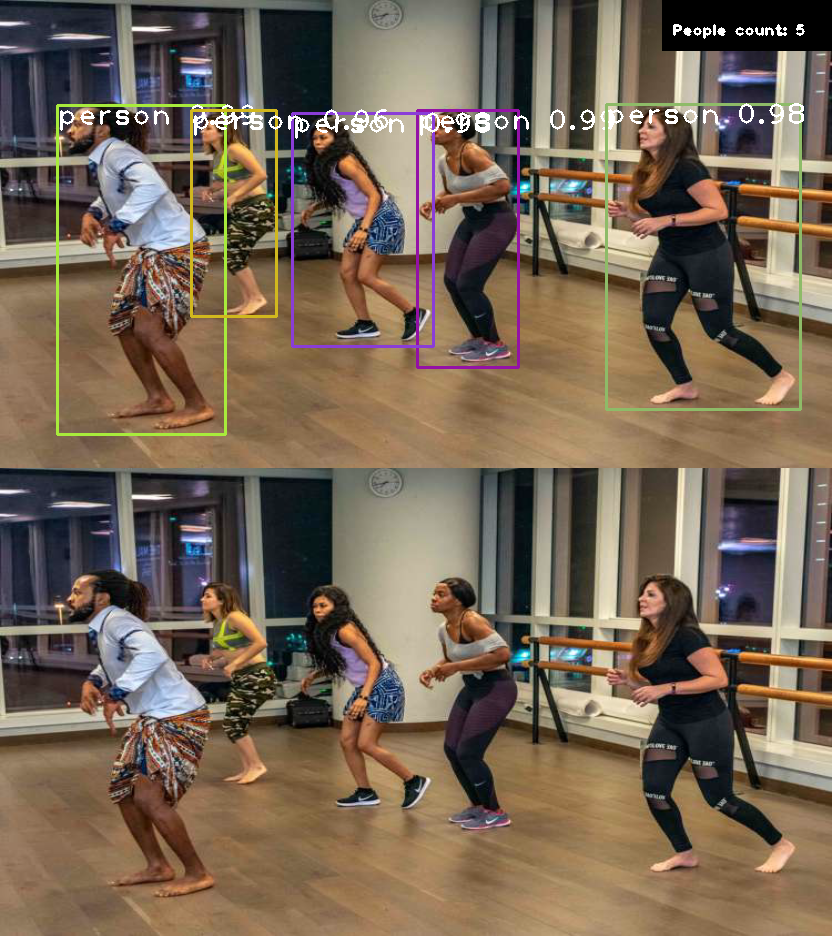

In [11]:
import numpy as np  # Tool for working with numbers and arrays
import cv2  # Tool for image and video processing
from google.colab.patches import cv2_imshow  # For displaying images
import requests  # For downloading files from the internet

# Download important files for our YOLO detective model
config_file = requests.get('https://raw.githubusercontent.com/AlexeyAB/darknet/master/cfg/yolov4.cfg', allow_redirects=True)
weights_file = requests.get('https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v3_optimal/yolov4.weights', allow_redirects=True)
coco_file = requests.get('https://raw.githubusercontent.com/kiyoshiiriemon/yolov4_darknet/master/cfg/coco.names', allow_redirects=True)

# Load the YOLO model
net = cv2.dnn.readNetFromDarknet(config_file.content, weights_file.content)

# Get list of object names (e.g., 'person', 'car', 'bottle')
classes = []
with coco_file as f:
    classes = f.content.decode('UTF-8').splitlines()

# These lines help YOLO run faster on special graphics cards
net.setPreferableBackend(cv2.dnn.DNN_BACKEND_CUDA)
net.setPreferableTarget(cv2.dnn.DNN_TARGET_CUDA)

# Example images (we'll analyze the third one here)
example_img = ('https://images.theconversation.com/files/447868/original/file-20220222-23-1jsr16x.jpg?ixlib=rb-1.1.0&q=45&auto=format&w=754&fit=clip',
               'https://watchmojo.blog/wp-content/uploads/2021/11/NiO89JoFb4OmkvhqhbM9hPAHE7tHyhkY1635869484-1.jpg',
               'https://res.cloudinary.com/hz3gmuqw6/image/upload/c_fill,q_60,w_750/v1/classpop/blog/group-of-dancers_6490f6b53367a.jpg')

# Load a video source (in this case, the third image from our list)
cap = cv2.VideoCapture(example_img[2]) ## ---> CHANGE NUMBER INSIDE THE BRACKETS [] TO SEE OTHER IMAGES!
font = cv2.FONT_HERSHEY_PLAIN
colors = np.random.uniform(0, 255, size=(100, 3))  # Colors for drawing boxes

while True:
    _, img = cap.read()  # Read a frame from the image

    key = cv2.waitKey(1)
    if key==27 or not _:  # Press 'Esc' or end of image to quit
        break

    # Resize the image for faster processing
    img = cv2.resize(img, (832, 468))
    height, width, _ = img.shape
    original_img = img.copy()  # Keep a copy of the original image

    # Prepare image data in a way YOLO understands
    blob = cv2.dnn.blobFromImage(img, 1/255, (288, 288), (0,0,0), swapRB=True, crop=False)
    net.setInput(blob)

    output_layers_names = net.getUnconnectedOutLayersNames()
    layerOutputs = net.forward(output_layers_names)

    boxes = []  # Will store potential bounding boxes
    confidences = []  # How confident YOLO is for each box
    class_ids = []  # The object type within each box

    for output in layerOutputs:
        for detection in output:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]

            # Only keep detections with high confidence
            if confidence > 0.4:
                # Calculate box coordinates
                center_x = int(detection[0]*width)
                center_y = int(detection[1]*height)
                w = int(detection[2]*width)
                h = int(detection[3]*height)
                x = int(center_x - w/2)
                y = int(center_y - h/2)
                boxes.append([x, y, w, h])
                confidences.append((float(confidence)))
                class_ids.append(class_id)
                # Get rid of overlapping boxes, keep the best ones
                indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.2, 0.4)

    num_persons = 0
    if len(indexes)>0:
        for i in indexes.flatten():
            x, y, w, h = boxes[i]
            label = str(classes[class_ids[i]])
            confidence = str(round(confidences[i],2))
            color = colors[i]

            # Focus only on detected 'person' objects
            if classes[class_ids[i]] == 'person':
                num_persons += 1  # Count people!
                cv2.rectangle(img, (x,y), (x+w, y+h), color, 2)  # Draw box around person
                cv2.putText(img, label + " " + confidence, (x, y+20), font, 2, (255,255,255), 2)

        # Display the total people count on the image
        cv2.rectangle(img, (img.shape[1] - 170, 0), (img.shape[1], 50), (0, 0, 0), -1)
        cv2.putText(img, f"People count: {num_persons}", (img.shape[1] - 160, 35),
                    font, 1, (255, 255, 255), 2)

    # Display processed image alongside the original for comparison
    combined_frame = np.zeros((original_img.shape[0] + img.shape[0], original_img.shape[1], 3), dtype=np.uint8)
    combined_frame[:img.shape[0], :original_img.shape[1]] = img
    combined_frame[img.shape[0]:, :original_img.shape[1]] = original_img
    cv2_imshow(combined_frame)

cap.release()
cv2.destroyAllWindows()